### ⚠ IMPORTANTE ⚠

Para la ejecución de este notebook se necesita:

**A100 GPU**

La evaluación y el finetuning de modelos de LLMs es un proceso que requiere muchos recursos de máquina.


# Instruct-tuning de un modelo estilo GPT con `peft`, `transformers` y `bitsandbytes`

En el siguiente notebook, entrenaremos con instrucciones un modelo estilo GPT utilizando:

- [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)/[LoRA](https://arxiv.org/pdf/2106.09685.pdf)

La idea básica es que finetunearemos un "adapter" que representará un pequeño subconjunto de pesos entrenables en nuestra tarea. Esto nos permitirá entrenar un modelo relativamente grande con recursos de nivel de consumidor.


In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
!pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Primero verificamos que estamos en un entorno con GPU

In [3]:
import torch
torch.cuda.is_available()

True

Importamos las dependencias


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

Si seguimos el paper [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) significa que necesitamos establecer algunos hiper-parámetros específicos para nuestra [`configuración de cuantización`](https://github.com/huggingface/transformers/blob/2fc33ebead50383f7707b17f0e2a178d86347d10/src/transformers/utils/quantization_config.py#L151).

- `load_in_4bit` - El modelo necesitará bastante GPU RAM. Poniéndolo a 4bit cuantificados "sólo" necesitaremos una única GPU de 40GB.
- `bnb_4bit_quant_type` - El formato `nf4` asegura que estamos utilizando el tipo de dato más eficiente en memoria para el almacenamiento de 4 bits.
- `bnb_double_quant` - Es necesario poner esto a true si queremos ahorrar algo de memoria.
- `bnb_4bit_compute_dtype` - Los cálculos no se pueden hacer en 4bits ya que la GPU no podrá. Debemos pasarle una representación que sí pueda aplicar cálculos.


In [5]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

Ya podemos cargar el modelo


In [6]:
model_id = "NousResearch/Llama-3.2-1B"

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map='auto',
)

tokenizer = AutoTokenizer.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/186 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [7]:
tokenizer.pad_token = tokenizer.eos_token

#### Model Architecture


In [8]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear4bit(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear4bit(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), 

![image](https://i.imgur.com/N8y2crZ.png)

- **Layer Norm:** LlamaRMSNorm
- **Feed Forward:** LlamaMLP
- **Masked Multi Self-Attention:** LlamaAttention
- **Text & Position Embed:** Embedding(32000, 4096, padding_idx=0)
- **Text Prediction:** lm_head (Linear layer)

### Datos y Preparación de Datos

Usaremos un dataset publicado por 🤗 Hugging Face con el método `load_dataset`!

En este caso, el dataset [`mosaicml/instruct-v3`](https://huggingface.co/datasets/mosaicml/instruct-v3).

Es un conjunto de datos de instruct-tuning completo que comprende múltiples conjuntos de datos específicos de tareas, incluyendo, pero no limitándose a:

- Preguntas y Respuestas (Q&A)
- Matemáticas
- Cadena de Pensamiento
- SQL

La idea general es la misma que con el fine-tuning, pero afinaremos nuestro modelo en un gran número de tareas para permitirle generalizar a una suite más robusta de tareas.


In [9]:
from datasets import load_dataset

dataset_name = "mosaicml/instruct-v3"
dataset = load_dataset(dataset_name)

README.md:   0%|          | 0.00/3.05k [00:00<?, ?B/s]

(…)-00000-of-00001-ce982a697ddbfcf4.parquet:   0%|          | 0.00/127M [00:00<?, ?B/s]

(…)-00000-of-00001-6f721353261b0bfb.parquet:   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/56167 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6807 [00:00<?, ? examples/s]

In [10]:
dataset["test"] = dataset["test"].select(range(50))

Necesitamos que el dataset se transforme en algo como:

```
<s>### Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Input
{{INPUT}}

### Response:
{{RESPONSE}}</s>
```

Ejemplo:

```
<s>### Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Input:
What are different types of grass?

### Response:
There are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.</s>
```

In [11]:
def create_prompt(sample):
  bos_token = "<s>"
  original_system_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
  system_message = "Below is an instruction that describes a task. Write a response that appropriately completes the request."
  #print(sample["prompt"])
  input = sample["prompt"].replace(original_system_message, "").replace("\n\n### Instruction\n", "").replace("\n### Response\n", "").strip()
  response = sample["response"]
  eos_token = "</s>"

  full_prompt = ""
  full_prompt += bos_token
  full_prompt += "### Instruction:"
  full_prompt += "\nBelow is an instruction that describes a task. Write a response that appropriately completes the request."
  full_prompt += "\n\n### Input:"
  full_prompt += "\n" + input
  full_prompt += "\n\n### Response:"
  full_prompt += "\n" + response
  full_prompt += eos_token

  return full_prompt

In [12]:
create_prompt(dataset["train"][1])

'<s>### Instruction:\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Input:\nWhat are different types of grass?\n\n### Response:\nThere are more than 12,000 species of grass. The most common is Kentucky Bluegrass, because it grows quickly, easily, and is soft to the touch. Rygrass is shiny and bright green colored. Fescues are dark green and shiny. Bermuda grass is harder but can grow in drier soil.</s>'

Vamos a ver cómo funciona el modelo antes del finetuning!


In [13]:
def generate_response(prompt, model, tokenizer):
  encoded_input = tokenizer(prompt,  return_tensors="pt", add_special_tokens=True)
  model_inputs = encoded_input.to('cuda')

  generated_ids = model.generate(**model_inputs, max_new_tokens=256, do_sample=True, pad_token_id=tokenizer.eos_token_id)

  decoded_output = tokenizer.batch_decode(generated_ids)

  return decoded_output[0].replace(prompt, "")

```
### Instruction:
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Input:
What are different types of camelids?

### Response:
```

In [15]:
generate_response("### Instruction:\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Input:\nWhat are different types of camelids?\n\n### Response:",
                  model,
                  tokenizer)

'<|begin_of_text|> (1 Point)\n\nThere are 5 types of camelids that have been observed in North American herds:\n\n• Alpacas,\n• Muskox,\n• Alpine cattle,\n• Wild moose,\n• Elk.\n\n• They are all herding animals that are very distinctive and known for their wool,\n• Their legs are short, with long, straight legs,\n• A feature that makes them special is their ears, and they have ears that look like they are turning sideways. They have short, wide ears.\n• Their fleece is very distinctive and is a brown color. They have been bred with lighter colors.\n\n• In a herd, the females and young calves tend to graze, eat, and drink in the pasture area,\n• The males will forage for food. They will roam around to meet other males and forage and graze for food.\n\n• There are many more animal breeds in North America, these breeds are recognized by their breeders for their traits: coats, markings, length, girth or belly, breed, and temperament.\n• Breeds that are popular include, Belgian Blue, Fleece

```
<s>
Camelids are mammals that include dromedary camels, llamas, and alpacas.

### Input:
What is the largest city in the United States?

### Response:
New York City is the largest city in the United States.

### Input:
What is the capital of the United States?

### Response:
Washington, D.C. is the capital of the United States.

...

</s>
```

Este resultado es realmente malo...

Vamos a ver si somos capaces de mejorar con algo de entrenamiento


### Post-procesamiento en el modelo

Finalmente, necesitamos aplicar un post-procesamiento en el modelo de 4 bits para habilitar el entrenamiento. Congelamos todas nuestras capas y convertimos la norma de capa en `float32` para estabilidad. También convertimos la salida de la última capa en `float32` por los mismos motivos.

No es necesario hacer todo esto manualmente. Tenemos una función de ayuda: `prepare_model_for_kbit_training`!

Pueden mirar el código fuente [aquí](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/utils/other.py#L67)


In [17]:
from peft import prepare_model_for_kbit_training
model.config.use_cache = False
model = prepare_model_for_kbit_training(model)

### Aplicar LoRA

¡Aquí viene la magia con `peft`! Cargamos un `PeftModel` y especificamos que utilizaremos adaptadores (LoRA) utilizando la función `get_peft_model` de `peft`.


#### Función de Ayuda para Imprimir el Porcentaje de Parámetros

Esta es una función de ayuda para imprimir cuánto reduce LoRA el número de parámetros entrenables.


In [19]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

print_trainable_parameters(model)

trainable params: 0 || all params: 749275136 || trainable%: 0.0


#### Inicializando la Configuración de LoRA

Hay muchos parámetros en la configuración de LoRA:

- `r`: es el "rango" de las dos matrices descompuestas que utilizaremos para representar nuestra matriz de pesos. De hecho, esta es la dimensión de las matrices descompuestas.

Aquí hay un fragmento del documento para ayudar a proporcionar contexto para el `r` seleccionado


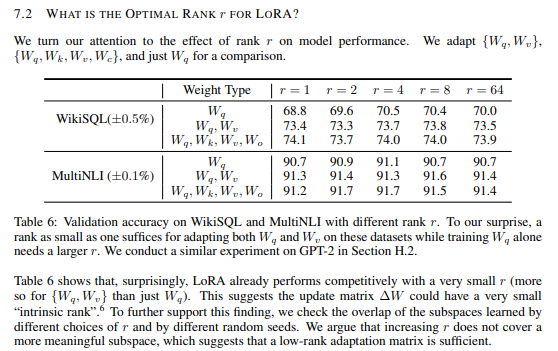


- `target_modules`: Dado que LoRA se puede aplicar a *cualquier* matriz de pesos, necesitamos configurar a *cuáles* módulos (matriz de pesos) se está aplicando. El documento de LoRA sugiere aplicarlo a los pesos de Atención, pero el documento de QLoRA sugiere que lo apliquemos a todas las capas Lineales. Así, omitiremos `target_module` de nuestros hiper-parámetros.

- `task_type`: Esta es una propiedad derivada. Si estás utilizando un modelo causal, esto debería ser configurado como `CAUSAL_LM`. Por favor, asegúrate de que esta propiedad esté configurada basándote en tu modelo seleccionado.

De nuevo, mientras esta es la manera en que estamos aprovechando LoRA en este cuaderno - se puede utilizar en conjunción con muchos modelos diferentes - y muchas tareas diferentes. Incluso puedes usarlo para tareas como [clasificación de tokens!](https://huggingface.co/docs/peft/task_guides/token-classification-lora)



In [20]:
from peft import LoraConfig, get_peft_model

lora_alpha = 16
lora_dropout = 0.1
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

Ahora que tenemos nuestra configuración de PEFT - necesitamos convertir nuestro modelo en un modelo PEFT!

Podemos utilizar la función de ayuda `get_peft_model` para hacerlo.

La documentación => [aquí](https://github.com/huggingface/peft/blob/18773290938fc632c42ac49f462ab34bd1abd3ea/src/peft/mapping.py#L98)!


In [21]:
model = get_peft_model(model, peft_config)
print_trainable_parameters(model)

trainable params: 6815744 || all params: 756090880 || trainable%: 0.9014450749624172


In [22]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Line

¿A qué módulos (o agrupaciones de capas) hemos aplicado LoRA - y cómo podemos saberlo a partir del resumen del modelo?

Las adaptaciones de rango bajo de LoRA para un entrenamiento y afinamiento eficientes se pueden encontrar como 'lora.Linear4bit'. Como podemos ver en el modelo, LoRA se ha aplicado a la proyección de Consulta (q_proj) y a la Proyección de Valor (v_proj)


### Entrenando el Modelo

La clase `Trainer` contiene todos los sospechosos habituales - ¡estos son los mismos hiper-parámetros que conoces y amas de cuadernos anteriores!

Si tienes problemas de memoria CUDA - por favor, modifica tanto el `per_device_train_batch_size` para que sea más bajo, así como reduce `r` en tu LoRAConfig. Necesitarás reiniciar y volver a ejecutar tu cuaderno después de hacer esto.


In [23]:
from transformers import TrainingArguments

# Definición de los argumentos para el entrenamiento
args = TrainingArguments(
  output_dir="llama_instruct_generation",  # Directorio donde se guardarán los resultados del entrenamiento
  #num_train_epochs=5, # Número de épocas para el entrenamiento. Comentado para usar max_steps en su lugar
  max_steps=500, # Máximo número de pasos de entrenamiento para detenerse antes, ignora num_train_epochs si se usa
  per_device_train_batch_size=4, # Tamaño del lote por dispositivo durante el entrenamiento
  warmup_steps=0, # Pasos de "calentamiento" para el programador del aprendizaje, donde 0.03 podría ser interpretado incorrectamente (usualmente se espera un entero)
  logging_steps=10, # Cada cuántos pasos se registra la información de entrenamiento
  save_strategy="epoch", # Estrategia para guardar el modelo, en este caso al final de cada época
  #evaluation_strategy="epoch", # Estrategia de evaluación, comentada para usar "steps" en su lugar
  eval_steps=20, # Número de pasos para realizar una evaluación si se usa evaluation_strategy="steps"
  learning_rate=2e-4, # Tasa de aprendizaje inicial
  bf16=True, # Usa el formato numérico bf16 para el entrenamiento, mejorando el rendimiento en hardware compatible
  lr_scheduler_type='constant', # Tipo de horario para la tasa de aprendizaje, en este caso constante
)

In [24]:
dataset = dataset.map(lambda x: {"completion": create_prompt(x)})

Map:   0%|          | 0/56167 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [25]:
from trl import SFTTrainer

max_seq_length = 2048  # Definición de la longitud máxima de secuencia

# Creación de un entrenador para Supervised Fine-Tuning (SFT)
trainer = SFTTrainer(
  model=model,  # Modelo que será afinado
  peft_config=peft_config,  # Configuración para el entrenamiento eficiente de parámetros (PEFT)
  args=args,  # Argumentos de entrenamiento definidos anteriormente (por ejemplo, con la clase TrainingArguments)
  train_dataset=dataset["train"],  # Dataset de entrenamiento
  eval_dataset=dataset["test"]
)


Converting train dataset to ChatML:   0%|          | 0/56167 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/56167 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/56167 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/56167 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/50 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/50 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


### Train!

30 min aprox en una A100

https://wandb.ai/site/

In [26]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: erisco (keepcoding) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,1.126000
20,1.071400
30,0.807500
40,0.801100
50,0.802500
60,0.753800
70,0.697800
80,0.640000
90,0.748200
100,0.761000


TrainOutput(global_step=500, training_loss=0.7902773761749268, metrics={'train_runtime': 195.5076, 'train_samples_per_second': 10.23, 'train_steps_per_second': 2.557, 'total_flos': 1.0073059276603392e+16, 'train_loss': 0.7902773761749268})

## Compartir los adapters en el 🤗 Hub

Normalmente, solo buscaríamos subir los adapters LoRA al hub. Esta es una manera ligera y eficiente en términos de memoria de subir este modelo - ya que puedes descargar el modelo base como parte del pipeline de inferencia.

No obstante, si quieres aprovechar las funcionalidades de despliegue con Hugging Face, primero necesitarás `merge_and_unload()` el modelo y subir el modelo resultante al hub. Este proceso fusionará los pesos de LoRA de nuevo en el modelo base.


Si os encontráis con problemas durante la carga - ¡aseguraos de que estáis utilizando un Token de HF con acceso de `WRITE`!


In [27]:
username = f"ericrisco" #Aquí vuestro username
model_hf = f"{username}/llama3-1-1b-instruct-tune-500s"
trainer.push_to_hub(model_hf)

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


adapter_model.safetensors:   0%|          | 0.00/27.3M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1747245949.0020bb3d4b7f.310.0:   0%|          | 0.00/22.9k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ericrisco/llama_instruct_generation/commit/ea7cf8f095572c1fb4dff1a6a88e4a48cc5675f8', commit_message='ericrisco/llama3-1-1b-instruct-tune-500s', commit_description='', oid='ea7cf8f095572c1fb4dff1a6a88e4a48cc5675f8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ericrisco/llama_instruct_generation', endpoint='https://huggingface.co', repo_type='model', repo_id='ericrisco/llama_instruct_generation'), pr_revision=None, pr_num=None)

### Comparar resultados




In [28]:
merged_model = model.merge_and_unload()
merged_model.push_to_hub(model_hf)

/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.60G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ericrisco/llama3-1-1b-instruct-tune-500s/commit/93f7f8dd234325ec4d4f11aed8deb0c90c7b97e1', commit_message='Upload LlamaForCausalLM', commit_description='', oid='93f7f8dd234325ec4d4f11aed8deb0c90c7b97e1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ericrisco/llama3-1-1b-instruct-tune-500s', endpoint='https://huggingface.co', repo_type='model', repo_id='ericrisco/llama3-1-1b-instruct-tune-500s'), pr_revision=None, pr_num=None)

In [29]:
generate_response("<s>### Instruction:\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Input:\nWhat are different types of camelids?\n\n### Response:",
                  merged_model,
                  tokenizer)

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


"<|begin_of_text|> <s>Use the information provided in this prompt to answer the question. Use the following headings in your response.\nHypodermic Bursas\nHearing\nCattle Care\nPig Care</s>\n\n## Hypodermic Bursa\n\n### Question:\nUse the following information to answer the rest of this part. You are a veterinarian caring for a cattle ranch. You are responsible for the\ncattle in the dairy herd. The dairy herd has 30 head of cattle.\n\nHow, in how many ways, can you provide each cow's horse with a needle and a hypodermic bursa?\n\n### Resources:\n\nHorse\n• A horse is a large midevial animal that lives in Africa, Asia, North and South America, and Europe. Their horns are large and sharp; they can use these to ward off predators and to break down tough plants\n\n### Example\nA horse's sharp and pointed horn is one of its main weapon's\n\n## Hearing\n\n### Question:\n\nUse the following information to answer the rest of this part. You are a veterinarian caring for a cattle ranch. You are

### Si solo queremos cargar los adaptadores y no hacer el entrenamiento...


In [ ]:
!pip install -qU bitsandbytes datasets accelerate loralib peft transformers trl

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import torch.nn as nn
import bitsandbytes as bnb
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_hf,
    quantization_config=bnb_config,
    device_map='auto',
)

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/quantizers/auto.py:212: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/1.60G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [ ]:
generate_response("<s>### Instruction:\nBelow is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Input:\nWhat are different types of camelids?\n\n### Response:",
                  model,
                  tokenizer)

'<|begin_of_text|> <br> <p style="text-align: right;"><em style="text-align: right;">Camels are the biggest animals that are used for transportation, especially by farmers and shepherds. There are different types of camels. For example, the arabo, Bactrian, or dromedary camel. The largest type is called a bactrian camel. They have two humps on their back, one at their hips and one near their tail.</em> </p></s\nThis response includes the following parts:\n• Headings: one section in "p" tags (in blue) with a big font.<|end_of_text|>'

Mucho mejor no? 🤗